In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
import copy
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

In [2]:
df=pd.read_excel('unisim_hist.xlsx')
df=df.drop(["Press_b", "Np_b", "Gp_b", "Wp_b", "Winj_b"], axis=1)
df.head()

Date  Press      Np        Gp  Wp  Winj
0 2013-05-31    332       0         0   0     0
1 2013-06-30    332       0         0   0     0
2 2013-07-31    331   61938   6858068   0     0
3 2013-08-31    329  124403  13532213   0     0
4 2013-09-30    328  182423  20112443   0     0

In [3]:
df.dtypes

Date     datetime64[ns]
Press             int64
Np                int64
Gp                int64
Wp                int64
Winj              int64
dtype: object

In [4]:
# Parametros escalares (MODSI)
phi = 0.136
k = 77
m = 0.0
N = 130286000
Rsi = 113.06
Bw = 1.0210
uw = 0.3
cf = 5.3E-05
pb = 210.3
bob = 1.414
co = 0.000162

In [5]:
df["t"] = (df["Date"]-df["Date"].iloc[0]).astype("int64")/10**9/60/60/24
df["dt"]=df["t"].diff()
df["p"] = df["Press"].iloc[0]-df["Press"]
df["dp"]=df["p"].diff()

In [6]:
df.head()

Date  Press      Np        Gp  Wp  Winj      t    dt  p   dp
0 2013-05-31    332       0         0   0     0    0.0   NaN  0  NaN
1 2013-06-30    332       0         0   0     0   30.0  30.0  0  0.0
2 2013-07-31    331   61938   6858068   0     0   61.0  31.0  1  1.0
3 2013-08-31    329  124403  13532213   0     0   92.0  31.0  3  2.0
4 2013-09-30    328  182423  20112443   0     0  122.0  30.0  4  1.0

In [7]:
df["Rp"] = df["Gp"]/df["Np"]

In [8]:
## PVT functions

def func_bo(p, a, b):
    bo1 = a*p[p<pb]+b 
    bo2 = bob+co*bob*(pb-p[p>=pb])
    return np.append(bo1, bo2)

def func_bg(p, a, b):
    return a*p**(b)

def func_rs(p, a, b):
    rs1 = a*p[p<pb]+b 
    rs2 = Rsi*np.ones(len(p[p>=pb]))
    return np.append(rs1, rs2)

In [9]:
p = df["Press"].values
bo =func_bo(p, 0.0012, 1.1538)
df["Bo"]=bo

In [10]:
bg=func_bg(p, 1.40676, -1.04229)
df["Bg"]=bg

In [11]:
rs=func_rs(p, 0.4655, 15.0114)
df["Rs"]=rs

In [12]:
df["Bt"]=df["Bo"]+(Rsi-df["Rs"])*df["Bg"]

In [13]:
df["F"] = df["Np"]*(df["Bt"]+(df["Rp"]-Rsi)*df["Bg"])+(df["Wp"]-df["Winj"])*Bw
df["Eo"] = df["Bt"]-df["Bt"].iloc[0]
df["Eg"] = df["Bt"].iloc[0]*(df["Bg"]/df["Bg"].iloc[0]-1)
df["We"] = df["F"]-N*(df["Eo"]+m*df["Eg"])
df["x"] = df["We"]/(df["Eo"]+m*df["Eg"])/1E6
df["y"] = df["F"]/(df["Eo"]+m*df["Eg"])/1E6

In [14]:
# df = df.set_index("Date")

In [15]:
df=df.dropna()
df.head()

Date  Press      Np        Gp  Wp  Winj      t    dt  p   dp  ...   
2 2013-07-31    331   61938   6858068   0     0   61.0  31.0  1  1.0  ...  \
3 2013-08-31    329  124403  13532213   0     0   92.0  31.0  3  2.0  ...   
4 2013-09-30    328  182423  20112443   0     0  122.0  30.0  4  1.0  ...   
5 2013-10-31    327  244857  26856741   0     0  153.0  31.0  5  1.0  ...   
6 2013-11-30    325  304107  33352071   0     0  183.0  30.0  7  2.0  ...   

         Bo        Bg      Rs        Bt              F        Eo        Eg   
2  1.386351  0.003325  113.06  1.386351   85386.862355  0.000229  0.004365  \
3  1.386810  0.003346  113.06  1.386810  170740.373583  0.000687  0.013176   
4  1.387039  0.003357  113.06  1.387039  251307.970237  0.000916  0.017623   
5  1.387268  0.003368  113.06  1.387268  336897.846261  0.001145  0.022098   
6  1.387726  0.003389  113.06  1.387726  418525.285723  0.001603  0.031132   

              We           x           y  
2   55542.508907  242.471707  372.757707  
3   81207.313238  118.170606  248.456606  
4  131930.556445  143.986236  274.272236  
5  187676.079021  163.860582  294.146582  
6  209614.811587  130.725257  261.011257  

[5 rows x 21 columns]

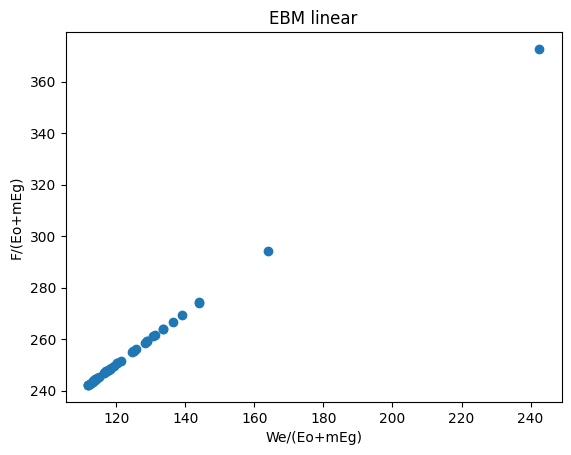

In [16]:
plt.scatter(df["x"], df["y"])
plt.title("EBM linear")
plt.xlabel("We/(Eo+mEg)")
plt.ylabel("F/(Eo+mEg)")
plt.show()

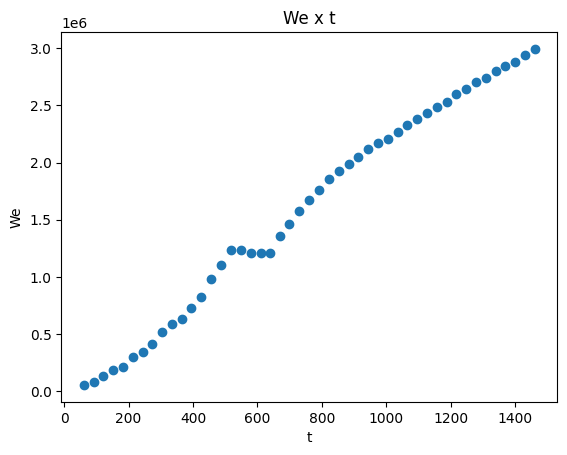

In [17]:
plt.scatter(df["t"], df["We"])
plt.title("We x t")
plt.xlabel("t")
plt.ylabel("We")
plt.show()

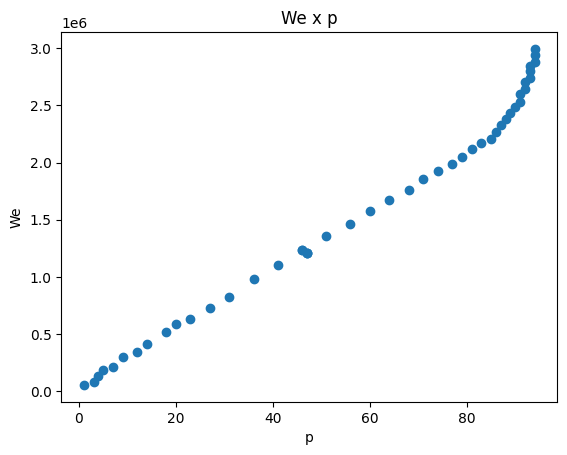

In [18]:
plt.scatter(df["p"], df["We"])
plt.title("We x p")
plt.xlabel("p")
plt.ylabel("We")
plt.show()

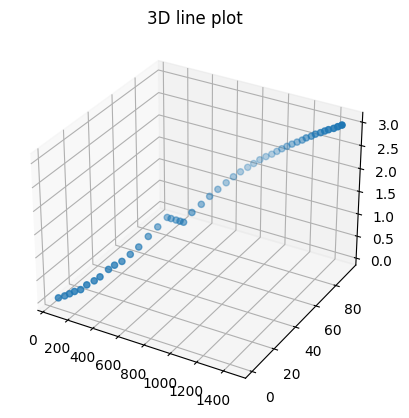

In [19]:
# syntax for 3-D projection
ax = plt.axes(projection ='3d')
 
# plotting
ax.scatter(df["t"], df["p"], df["We"])
# ax.plot3D(x, y, z, 'green')
ax.set_title('3D line plot')
plt.show()

In [20]:
train = df.copy()

In [21]:
FEATURES_we = ["t", "p"]
TARGET_we = "We"

In [22]:
X_train_we = train[FEATURES_we]
y_train_we = train[TARGET_we]

In [23]:
reg_we = xgb.XGBRegressor()
reg_we.fit(X_train_we, y_train_we)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [24]:
reg_we.score(X_train_we, y_train_we)

0.9999999877637197

In [25]:
reg_we.predict(X_train_we)

array([  55608.723,   81128.65 ,  132038.47 ,  187687.88 ,  209617.75 ,
        296558.6  ,  345646.78 ,  413298.44 ,  515204.9  ,  590438.2  ,
        633453.75 ,  726541.5  ,  827845.5  ,  978094.9  , 1106700.1  ,
       1234188.2  , 1234188.2  , 1204802.1  , 1204802.1  , 1204802.1  ,
       1359462.5  , 1458190.4  , 1574512.1  , 1669603.5  , 1756415.9  ,
       1851614.9  , 1922252.1  , 1983267.   , 2049294.2  , 2115682.   ,
       2167943.5  , 2203017.   , 2267998.8  , 2327618.2  , 2383579.2  ,
       2434417.8  , 2481630.2  , 2529094.8  , 2598189.8  , 2638689.8  ,
       2704090.8  , 2739844.8  , 2797135.   , 2846669.8  , 2878239.8  ,
       2935685.8  , 2992933.   ], dtype=float32)

In [26]:
df["We_Pred"] = reg_we.predict(X_train_we)

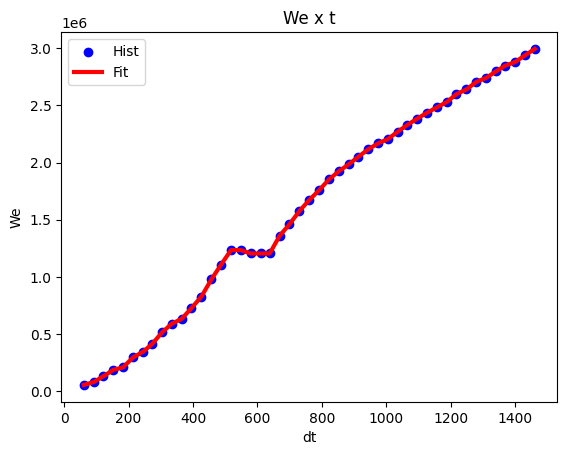

In [27]:
plt.scatter(df["t"], df["We"], label="Hist", color="blue")
plt.plot(df["t"], df["We_Pred"], label="Fit", color="red", linewidth=3)
plt.title("We x t")
plt.legend()
plt.xlabel("dt")
plt.ylabel("We")
plt.show()

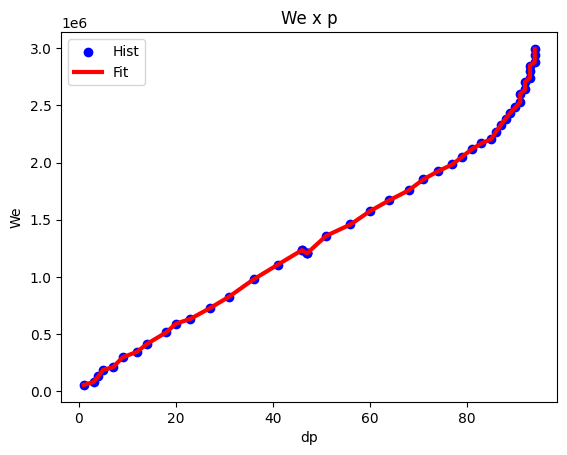

In [28]:
plt.scatter(df["p"], df["We"], label="Hist", color="blue")
plt.plot(df["p"], df["We_Pred"], label="Fit", color="red", linewidth=3)
plt.title("We x p")
plt.legend()
plt.xlabel("dp")
plt.ylabel("We")
plt.show()

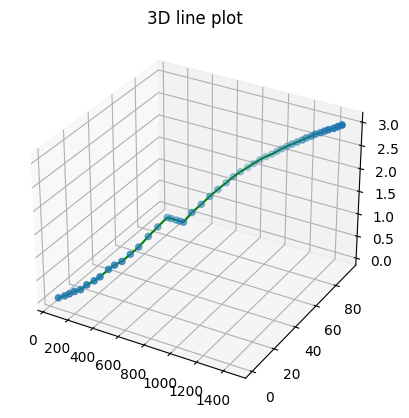

In [29]:
# syntax for 3-D projection
ax = plt.axes(projection ='3d')
 
# plotting
ax.scatter(df["t"], df["p"], df["We"])
ax.plot3D(df["t"], df["p"], df["We_Pred"], 'green')
ax.set_title('3D line plot')
plt.show()

In [30]:
train=df.copy()

In [31]:
FEATURES_press= ["F", "Eo", "Eg", "We_Pred"]
TARGET_press = "Press"

In [32]:
X_train_press = train[FEATURES_press]
y_train_press = train[TARGET_press]

In [33]:
reg_press = xgb.XGBRegressor()
reg_press.fit(X_train_press, y_train_press)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [34]:
reg_press.score(X_train_press, y_train_press)

0.9999999924445789

In [35]:
reg_press.predict(X_train_press)

array([330.998  , 329.001  , 327.99854, 326.99973, 325.00095, 322.99905,
       320.00424, 317.99646, 314.00323, 311.99707, 309.00336, 304.99927,
       300.9956 , 296.00528, 290.99344, 285.99985, 285.99985, 285.00015,
       285.00015, 285.00015, 281.00537, 275.99527, 272.00076, 268.00406,
       263.99646, 261.00348, 257.9961 , 255.00037, 253.00305, 250.99507,
       248.99986, 247.00381, 245.99678, 244.99986, 244.00363, 242.99739,
       242.00346, 241.0007 , 241.0007 , 239.9987 , 239.9987 , 239.00002,
       239.00002, 239.00002, 238.00052, 238.00052, 238.00052],
      dtype=float32)

In [36]:
df["Press_Pred"] = reg_press.predict(X_train_press)

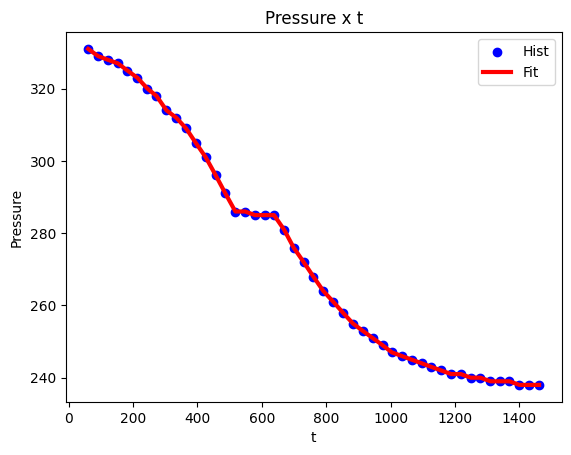

In [37]:
plt.scatter(df["t"], df["Press"], label="Hist", color="blue")
plt.plot(df["t"], df["Press_Pred"], label="Fit", color="red", linewidth=3)
plt.title("Pressure x t")
plt.legend()
plt.xlabel("t")
plt.ylabel("Pressure")
plt.show()

In [38]:
reg_we.save_model('unisim-d_we.json')
reg_press.save_model('unisim-d_press.json')
df.to_excel('unisim_hist_match.xlsx', index=True)